# TM10007 Group 4 -- ECG Data
Lara de Bats (5022037), Josefien van den Berg (4663381), Merel Goossens (4856902), Amber Liqui Lung (4464168)

In this assignment we wil test certain classifiers in order to create a classifier model to distinguish between normal and abnormal ECG's. The code is divided in different segments that are explained in our report.

In [8]:
# Loading packages
import zipfile
import os
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pylab as pl
import plotly.express as px
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, average_precision_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn import set_config

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

pd.set_option('display.max_rows', 5)

## 1. Data loading and initial split

Below we load the ECG data, convert it to a dataframe an clean the data.First we are going to start with loading the CS file into a dataframe. Then we are going to split the dataset into test data and training data.

In [9]:
# Load CSV file into dataframe
!git clone https://github.com/JosefienBerg/TM10007_ML_ECG_group4.git

with zipfile.ZipFile('/content/TM10007_ML_ECG_group4/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/TM10007_ML_ECG_group4/ecg')

df = pd.read_csv('/content/TM10007_ML_ECG_group4/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(df.index)}')
print(f'The number of columns: {len(df.columns)}')

Cloning into 'TM10007_ML_ECG_group4'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 334 (delta 146), reused 96 (delta 59), pack-reused 124
Receiving objects: 100% (334/334), 91.95 MiB | 22.95 MiB/s, done.
Resolving deltas: 100% (183/183), done.
The number of samples: 827
The number of columns: 9001


We explore our dataset to see how many patients we have with label 1 and how many with lable 0.


In [10]:
# How many patients have a normal or abnormal ECG?
count0= (df['label'] == 0).sum()
count1= (df['label'] == 1).sum()
print(f'There are {count0} patients with label 0')
print(f'There are {count1} patients with label 1')
# Since the majority of patients has no abnormalities we can conclude that label 0 is normal and label 1 is abnormal 

There are 681 patients with label 0
There are 146 patients with label 1


Now we will perform our initial split

In [11]:
# Split the whole data set in a training and test set
features = df.loc[:, df.columns !="label"].to_numpy()
labels = df["label"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split (features, labels, train_size = 0.8, random_state = 42) 
print(f"The training set has {x_train.shape[0]} samples and {x_train.shape[1]} features with {y_train.shape[0]} labels")
print(f"The test has {x_test.shape[0]} samples and {x_test.shape[1]} features with {y_test.shape[0]} labels")

The training set has 661 samples and 9000 features with 661 labels
The test has 166 samples and 9000 features with 166 labels


## 2. Imputation

In [12]:
# block 1

In [13]:
# block 2

## 3. Data scaling, extraction and feature selection
In this section we will explore multiple scaling methods, determine if we will use PCA and define the treshold and we will explore mutliple feature selection methods. After this section we will have a dictionary containing the x_train data for all combinations of the chosen scaling, extraction (PCA) and selection methods.


There are multiple ways to scale features by standarization and normalization.

In [14]:
# 1. Standardization of the data
scaler_standard = StandardScaler()
x_scaled_standard = scaler_standard.fit_transform(x_train) 

# 1. Min-max scaling
scaler_minmax = MinMaxScaler()
x_scaled_minmax = scaler_minmax.fit_transform(x_train)

# # 2. Robust scaling --> Robust is removed due to a to extensive loading time during the training of SVC
# scaler_robust= RobustScaler()
# x_scaled_robust = scaler_robust.fit_transform(x_train)

x_scaled = {"standard":x_scaled_standard, "minmax":x_scaled_minmax}

Now we are going to perform PCA and determine the treshold.

(661, 275)


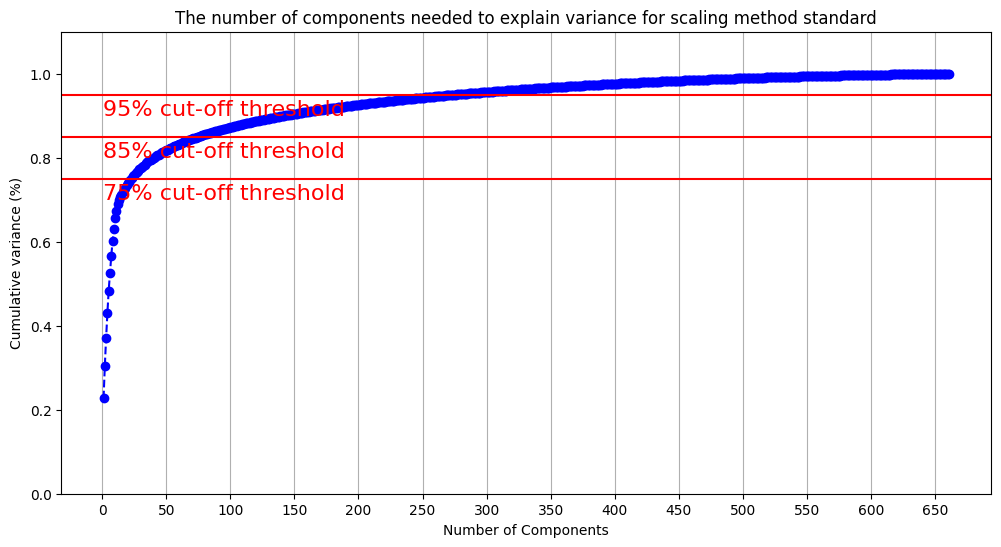

(661, 306)


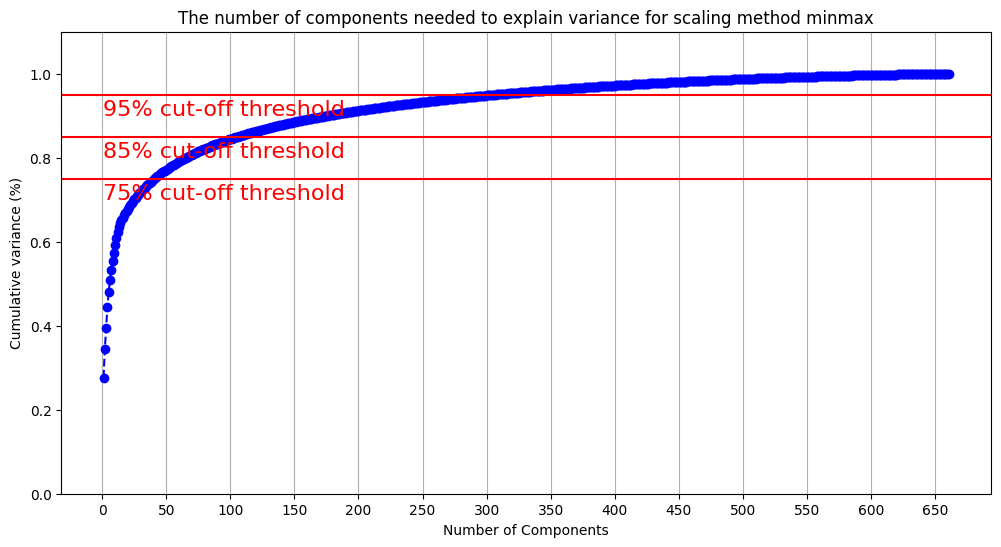

In [15]:
# PCA
plt.close('all') #before plotting, close all old windows
x_scaled_pca = {} #create dictionary to add all combinations of scaling combined with PCA to

for key, x in x_scaled.items():
    
    # applying pca
    pca_setting = PCA(n_components = 0.95) # threshold at 95% method
    x_pca = pca_setting.fit_transform(x)
    x_scaled_pca[f"x_{key}_PCA"] = x_pca

    print(x_pca.shape)

    # plot to show treshold choice
    pca_figure = PCA().fit(x)
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, 662, step=1)
    y = np.cumsum(pca_figure.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, 661, step=50)) #change from 0-based array index to 1-based human-readable label
    plt.ylabel('Cumulative variance (%)')
    plt.title(f'The number of components needed to explain variance for scaling method {key}')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.9, '95% cut-off threshold', color = 'red', fontsize=16)

    plt.axhline(y=0.85, color='r', linestyle='-')
    plt.text(0.5, 0.8, '85% cut-off threshold', color = 'red', fontsize=16)

    plt.axhline(y=0.75, color='r', linestyle='-')
    plt.text(0.5, 0.7, '75% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='x')
    plt.show()

Lasty we will look at feature selection. 

In [16]:
# Feature selection with and without PCA
x_scaled_selected = {} #create dictionary to add all combinations of scaling with or without PCA combined with feature selection

selector = SelectKBest(f_classif)
k = 10

#Including PCA
for key, x in x_scaled_pca.items():
    selector.k = k
    x_train_ffs = selector.fit_transform(x_train, y_train)  # ffs = f-test feature selection
    x_scaled_selected[f"{key}_ffs"] =  x_train_ffs

#Exclusing PCA
for key, x in x_scaled.items():
    selector.k = k
    x_train_ffs = selector.fit_transform(x_train, y_train)  # ffs = f-test feature selection
    x_scaled_selected[f"x_{key}_ffs"] =  x_train_ffs

Now we finish with a dictionary x_scaled_selected that inclused all combinations between feature scaling, feature extraction (PCA) and feature selection.

## 4. Classifiers: hyperparameter tuning and fitting
In this section we will build a neural network and train our different clasiffiers (standard and the neural network) and compare their functionality in terms of F1 and average precision. We will perform this for all possible combinations of scaling, selection and classification possibilities. This is also the section were we will tune our parameters.

First we are going to set the models and parameters we are going to tune and write the function for tuning. 

In [59]:
# # Creating a dictionary of all proposed classifiers
models = {"GaussianNB": GaussianNB(),
          "KNeighborsClassifier": KNeighborsClassifier(),
          "RandomForestClassifier":RandomForestClassifier(),
          #"SVC":SVC(),
          "MLP": MLPClassifier()}

# Creating a dictionary of all models with default paramters (note; random state=42 only added in the last run)
model_parameters = {"GaussianNB": {}, #no parameters to be set
                    "KNeighborsClassifier":{"n_neighbors":[x for x in range(20, 300)], "weights": ["distance", "uniform"]},
                    "RandomForestClassifier":{"n_estimators":[x for x in range(5,10)], "max_depth":[x for x in range (1,20)], "min_samples_leaf": [x for x in range (1, 20)]},
                    #"SVC":{"C": np.logspace(-2, 5, num=10), "kernel": ["linear", "rbf", "poly"], "degree":[x for x in range (2,4)]},
                    "MLP": {"hidden_layer_sizes": [50], "activation": ["relu", "logistic"], "solver": ["sgd", "adam"],  "learning_rate_init": [0.001], "alpha": [0.05], "learning_rate": ["adaptive"], "max_iter":[50]}
                    }

# Function to clean up results and create dataframe with wanted results
def get_dataframe_from_results(results, scoring):
  """ This function makes sure that we can clean up the results that we get from the grid search and leaves is with the necessary results"""
  df_to_concat = [pd.DataFrame(results["params"])]

  for key in scoring:
    df_to_concat.append(pd.DataFrame(results[f"mean_test_{key}"], columns=[key]))

  return pd.concat(df_to_concat, axis=1)

# Function to do a grid search on each model using the parameters in the model_parameter dictionary
def parametertuning(Models, ModelParameters, n_splits, random_state, scoring, refit, X, Y):
  """ This function performs the parameter tuning by doing a gridsearch with multiple parameters per model it returns the results that are cleaned up and only show the necessary"""
  results = {} #create a dictionary to save results

  for model_name, parameters in ModelParameters.items():
    print(f"Grid searching {model_name}")
    model = Models[model_name]  # Find corresponding model in models dict

    # Create the Cross vallidation object
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)  
    
    # Perform a grid search for the best parameters for the model using the test data and KFold
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, scoring=scoring, refit=refit) 
    grid_search.fit(X, Y)
    
    # Results of grid search
    best_estimator = grid_search.best_estimator_ # Returns the model with the best parameters filled in based on refit scoring metric
    grid_search_results = get_dataframe_from_results(grid_search.cv_results_, scoring) # Extracts the necessary results 

    #Compute the mean accuracy for every BestEstimator to compare with the 85% mentioned in the assignment
    accuracy = best_estimator.fit(X, Y).score

    # Add the results to the dictionary
    results[model_name] = {"BestEstimator": best_estimator, "Accuracy":accuracy, "GSresults": grid_search_results}
  
  return results

Now we are going write the function to plot the relation between the scoring type and certain parameters in order to prove that we chose the right parameter combinations.

In [81]:
# Since we do not tune any paramters in GaussianNB we don't need to make a plot

#---------------Plot for KNeighborsClassifier---------------
def plot_knn(results, scoring, combination_name):
  knn_df = results["KNeighborsClassifier"]["GSresults"]
  uni_knn_df = knn_df[knn_df["weights"] == "uniform"]
  dist_knn_df = knn_df[knn_df["weights"] == "distance"]

  for key in scoring:
    index_maxscore = knn_df[key].idxmax()

    plt.plot(uni_knn_df["n_neighbors"].to_numpy(), uni_knn_df[key].to_numpy(), label= "uniform")
    plt.plot(dist_knn_df["n_neighbors"].to_numpy(), dist_knn_df[key].to_numpy(), label= "distance")
    plt.scatter(knn_df["n_neighbors"][index_maxscore], knn_df[key].max(), s= 200, marker = "*", c="m")

    plt.legend()
    plt.title(f"The relation between the {key} of the KNN classifier and the parameters {combination_name}")
    plt.xlabel("N-neighbour")
    plt.ylabel(f"{key}")
    plt.show()

#---------------Plot for SVC Classifier--------------- 
def plot_svc(results, scoring, combination_name):
  svc_df = results["SVC"]["GSresults"]
  linear_svc_df = svc_df[svc_df["kernel"]=="linear"]
  rbf_svc_df = svc_df[svc_df["kernel"]=="rbf"]
  poly_svc_df = svc_df[svc_df["kernel"]=="poly"]

  for key in scoring:
    index_maxscore = svc_df[key].idxmax()

    for i in range(2,5):
      degree_svc_df = poly_svc_df[poly_svc_df["degree"]==i]
      plt.plot(degree_svc_df["C"].to_numpy(), degree_svc_df[key].to_numpy(), label= f"poly degree {i}")

    plt.plot(linear_svc_df["C"].to_numpy(), linear_svc_df[key].to_numpy(), label= "linear")
    plt.plot(rbf_svc_df["C"].to_numpy(), rbf_svc_df[key].to_numpy(), label= "rbf")
    plt.scatter(svc_df["C"][index_maxscore], svc_df[key].max(), s = 200, marker = "*", c="m")

    plt.legend()
    plt.title(f"The relation between the {key} of the SVC classifier and the parameters {combination_name}")
    plt.xscale("log")
    plt.xlabel("C-value")
    plt.ylabel(f"{key}")
    plt.show()

# ---------------Plots for RandomForestClassifier---------------
def plot_randomforest(results, scoring, combination_name):
  forest_df = results["RandomForestClassifier"]["GSresults"]

  for key in scoring:
    index_maxscore = forest_df[key].idxmax() #index (number of the row)
    x_marker= forest_df["max_depth"][index_maxscore]
    y_marker= forest_df["min_samples_leaf"][index_maxscore]
    z_marker= forest_df["n_estimators"][index_maxscore] 

    fig = px.scatter_3d(forest_df, x="max_depth", y="min_samples_leaf", z="n_estimators", color=key,  title=f"The relation between the {key} of the Random Forest and the parameters {combination_name}")
    fig.add_trace(go.Scatter3d(x=[x_marker], y=[y_marker], z=[z_marker], mode = 'markers', marker=dict(color='LightSkyBlue', size=20, symbol='diamond')))
   
  
    fig.show()

Beneath, we write the function to display the best scoring results for each model.

In [27]:
# Plot tabel with scoring metric and optimal paramater combination per scalor and selection
def create_table_of_results(results_all_combinations, combination_name):
  F1_scores = []
  Average_Precision_scores = []
  Mean_accuracy = []
  model_names = [] 

  results = results_all_combinations[combination_name]

  for model_name in results:
    F1 = results[model_name]["GSresults"]["F1"].max()
    Average_Precision = results[model_name]["GSresults"]["Average Precision"].max()
    mean_accuracy = results[model_name]["Accuracy"]
    F1_scores.append(F1)
    Average_Precision_scores.append(Average_Precision)
    Mean_accuracy.append(mean_accuracy)
    model_names.append(model_name)

  print(f"Table of results for combination {combination_name}")
  display(pd.DataFrame({"ModelName":model_names, "F1":F1_scores, "Average Precision":Average_Precision_scores, "Mean accuracy of BestEstimator":Mean_accuracy}).style.hide(axis='index'))
  print()

Lastly, we will call all functions written to tune all the parameters and plot the results for each combination of scaling, PCA and selection.

In [28]:
# Perform training
results_all_combinations = {}
for combination_name, data in x_scaled_selected.items():
  print(combination_name)
  
  # Perform grid search
  f1_scorer = make_scorer(f1_score, labels = None, average = 'binary', pos_label = 1) 
  average_precision_scorer = make_scorer(average_precision_score, pos_label = 1)
  scoring = {"F1":f1_scorer, "Average Precision":average_precision_scorer} #Determine what type of scoring you want to use
  
  results = parametertuning(models, model_parameters, 5, None, scoring, "Average Precision", data, y_train)
  results_all_combinations[combination_name] = results

x_standard_PCA_ffs
Grid searching GaussianNB
Grid searching KNeighborsClassifier
Grid searching RandomForestClassifier
Grid searching MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


x_minmax_PCA_ffs
Grid searching GaussianNB
Grid searching KNeighborsClassifier
Grid searching RandomForestClassifier
Grid searching MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


x_standard_ffs
Grid searching GaussianNB
Grid searching KNeighborsClassifier
Grid searching RandomForestClassifier
Grid searching MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


x_minmax_ffs
Grid searching GaussianNB
Grid searching KNeighborsClassifier
Grid searching RandomForestClassifier
Grid searching MLP


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


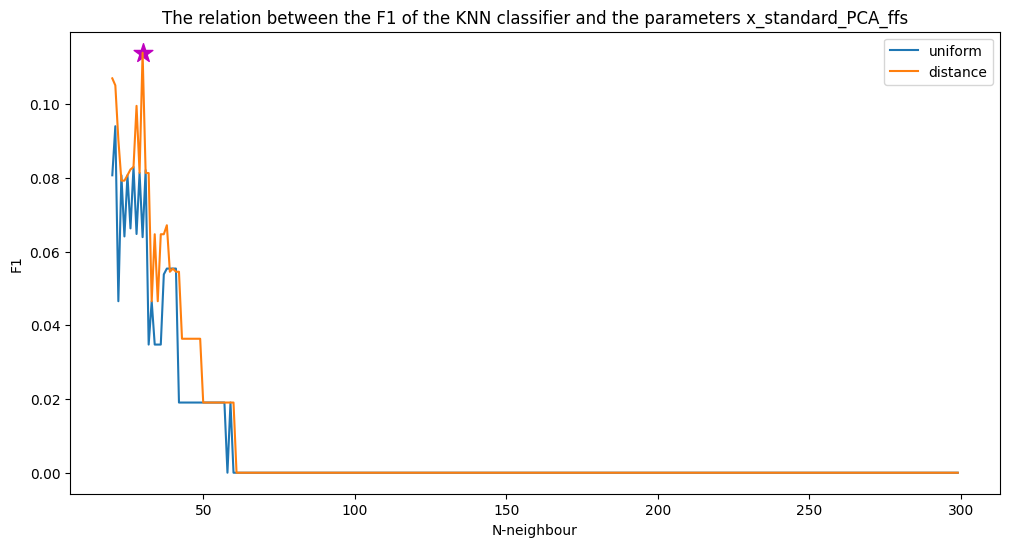

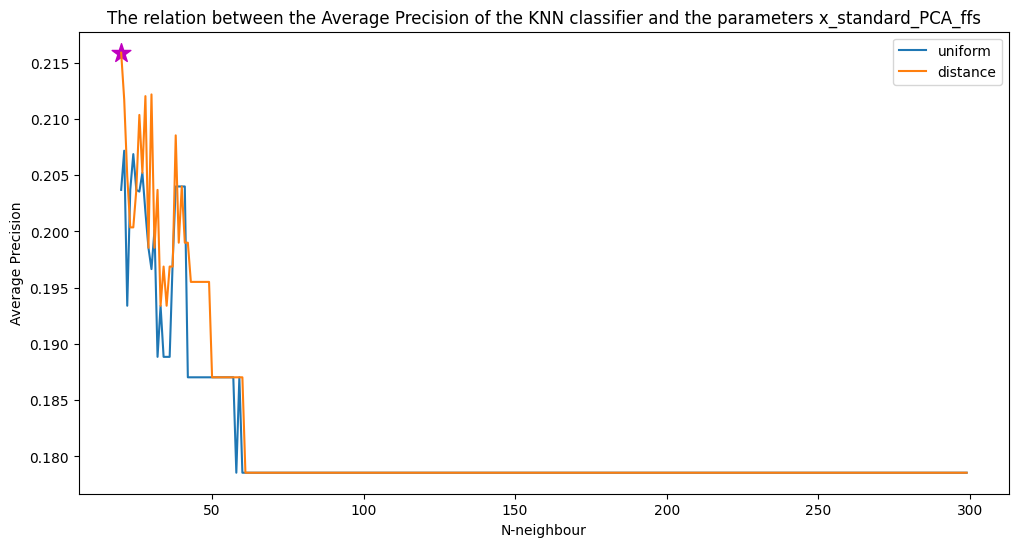

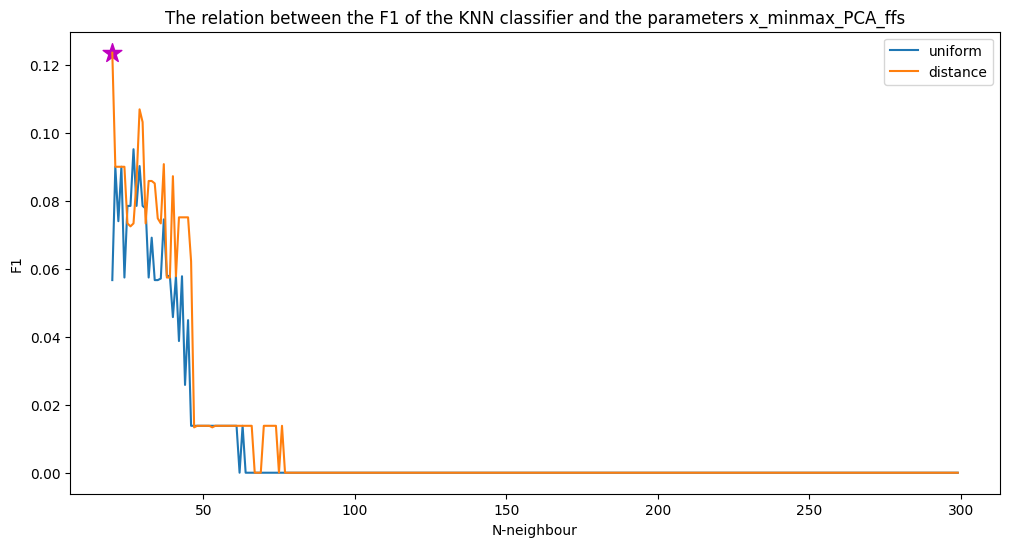

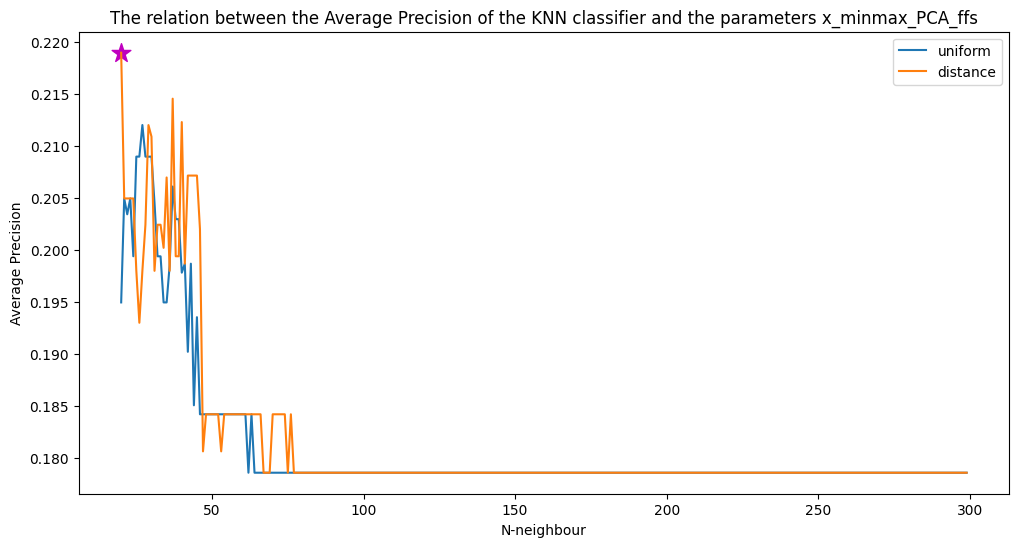

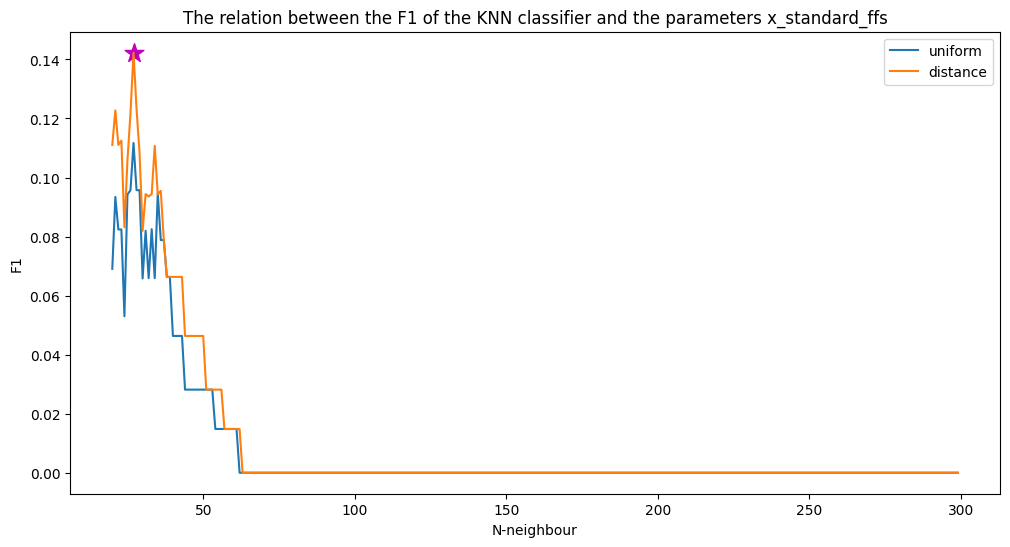

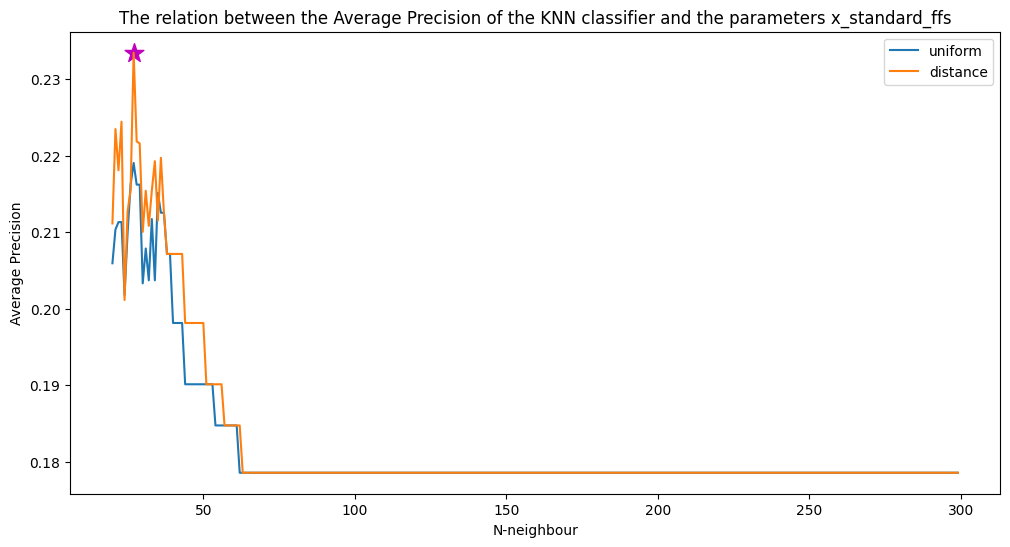

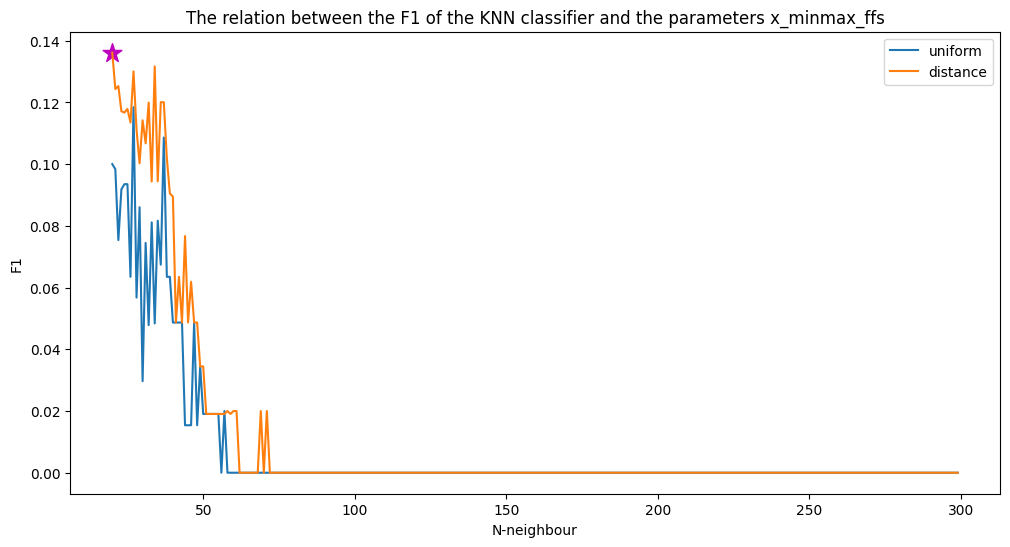

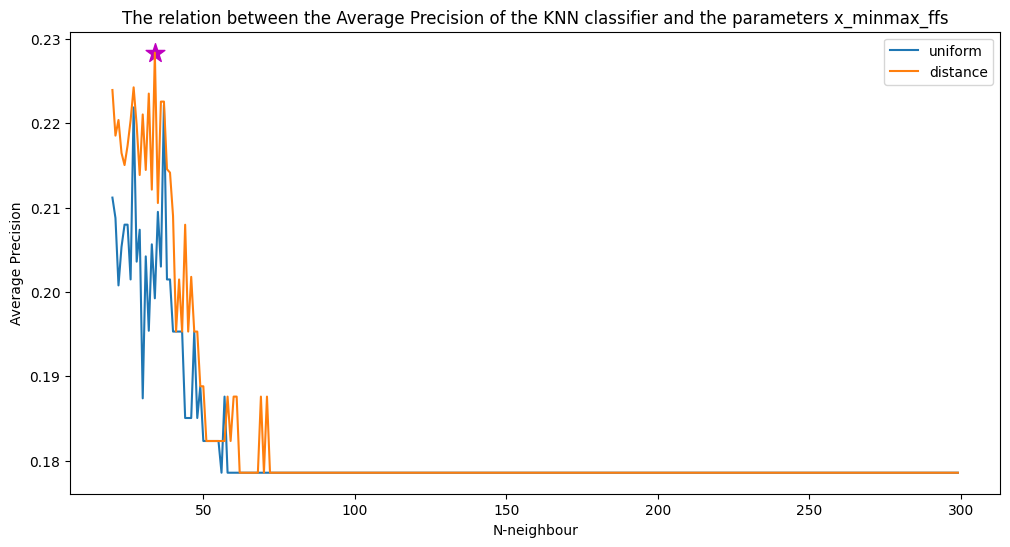

In [82]:
# Create visualization of results 
plt.close('all') #make sure you class all windows before plotting to prevent plotting in the same figure

for combination_name, data in x_scaled_selected.items():

  #Create all plots to show the relation between the scoring type and parameters for every combination
  plot_knn(results_all_combinations[combination_name], scoring, combination_name)
  # plot_svc(results_all_combinations[combination_name], scoring, combination_name)
  plot_randomforest(results_all_combinations[combination_name], scoring, combination_name)

In [58]:
# Create table with results for every combination
for combination_name, data in x_scaled_selected.items():
  create_table_of_results(results_all_combinations, combination_name)

Table of results for combination x_standard_PCA_ffs


ModelName,F1,Average Precision,Mean accuracy of BestEstimator
GaussianNB,0.417337,0.307345,
KNeighborsClassifier,0.113997,0.215897,
RandomForestClassifier,0.405118,0.345438,
MLP,0.264237,0.211020,



Table of results for combination x_minmax_PCA_ffs


ModelName,F1,Average Precision,Mean accuracy of BestEstimator
GaussianNB,0.414869,0.305259,
KNeighborsClassifier,0.123465,0.218982,
RandomForestClassifier,0.429552,0.348360,
MLP,0.267486,0.210280,



Table of results for combination x_standard_ffs


ModelName,F1,Average Precision,Mean accuracy of BestEstimator
GaussianNB,0.426460,0.321356,
KNeighborsClassifier,0.142271,0.233455,
RandomForestClassifier,0.441551,0.361589,
MLP,0.215917,0.195302,



Table of results for combination x_minmax_ffs


ModelName,F1,Average Precision,Mean accuracy of BestEstimator
GaussianNB,0.416473,0.300232,
KNeighborsClassifier,0.136125,0.228349,
RandomForestClassifier,0.439869,0.354065,
MLP,0.265931,0.220350,


## 5. The final model
After the previous steps we determined the best combination of scaling, PCA, feature selection and classification for our final model. Underneath we wrote the final pipeline that returns the mean accuracy of the model on the test data.

In [ ]:
# # Write final pipeline with chosen combinations
# def final_pipeline(x_train, y_train, x_test, y_test):

#   # Determine steps of the pipeline
#   pipe = Pipeline([('scaler', MinMaxScaler()), ('pca', PCA(n_components = 0.95)), ('svc', SVC(C=1, kernel= "rbf"))])

#   # Visualize the pipeline
#   set_config(display = "diagram")
#   pipe

#   # Fit the pipeline on the training data 
#   pipe.fit(x_train, y_train)

#   # Compute the mean accuracy of the model on the test data
#   score = pipe.score(x_test, y_test) #Returns the mean accuracy of the model on test data
#   return score

# #Execute pipeline to get the mean accuracy of the final model on the test data
# accuracy = final_pipeline(x_train, y_train, x_test, y_test)
# print(f"The accuracy of the final model on the test data is {accuracy}")
